In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from petastorm import make_reader
from petastorm.pytorch import DataLoader as PetastormDataLoader
from src.utils import read_yaml
from src.models.tasks import get_task_from_config_path         

from matplotlib import pyplot as plt
import seaborn as sns

Extension horovod.torch has not been built: /homes/gws/mikeam/miniconda3/envs/seattleflustudy/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [2]:
TASK_PATH = "/homes/gws/mikeam/seattleflustudy/src/data/task_configs/PredictFluPos.yaml"
TRAIN_DATA_PATH = "/homes/gws/mikeam/seattleflustudy/new_dataset/split-2020-02-10/train_minute_petastorm"
VAL_DATA_PATH = "/homes/gws/mikeam/seattleflustudy/new_dataset/split-2020-02-10/eval_minute_petastorm"

In [3]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

import pyspark.sql.types as sql_types
from pyspark.sql import functions as f
from pyspark.sql.functions import col

from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark import SparkContext

SPARK_CONFIG = [ 
    ("spark.master","local[95]"),
    ("spark.ui.port","4050"),
    ("spark.executor.memory","750g"),
    ('spark.driver.memory',  '2000g'),
    ("spark.driver.maxResultSize", '0'), # unlimited
    ("spark.network.timeout",            "10000001"),
    ("spark.executor.heartbeatInterval", "10000000")]   

conf = SparkConf().setAll(SPARK_CONFIG)
sc = SparkContext(conf=conf, appName="PetaStorm Conversion")
spark = SparkSession(sc)

21/11/29 08:53:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/29 08:53:46 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


In [4]:
train_df = spark.read.parquet(TRAIN_DATA_PATH).sample(fraction=0.1).toPandas()
val_df = spark.read.parquet(VAL_DATA_PATH).sample(fraction=0.1).toPandas()

Do the features have similar distributions? (They were normalized in petastorm, so they should)

In [5]:
FEATURE_COLUMNS = ["heart_rate","steps","missing_heart_rate","missing_steps"] + [f"sleep_classic_{i}" for i in range(4)]
def plot_train_val_means(train_df,val_df):
    train_df["type"] = "train"
    val_df["type"] = "val"
    all_df = pd.concat([train_df,val_df],axis=0)
    all_df.groupby("type")[FEATURE_COLUMNS].aggregate(lambda x: np.concatenate(x.values).mean())
    
    mean_by_day = all_df.groupby(["type","end"])[FEATURE_COLUMNS].aggregate(lambda x: np.concatenate(x.values).mean())
    val_mean_by_day = mean_by_day.xs("val",level=0)
    train_mean_by_day = mean_by_day.xs("val",level=0)
    
    stacked_daily_means = mean_by_day.stack().rename("value").reset_index()
    stacked_daily_means = stacked_daily_means.rename(columns={"level_2":"stream"})
    
    g = sns.FacetGrid(
    data=stacked_daily_means,
    col="stream", hue="type",
    palette="crest",  
    col_wrap=2, height=5, aspect=1.5, sharey=False
    )
    
    g.map(plt.plot, "end", "value", marker="o", linewidth=4)
    
    return g

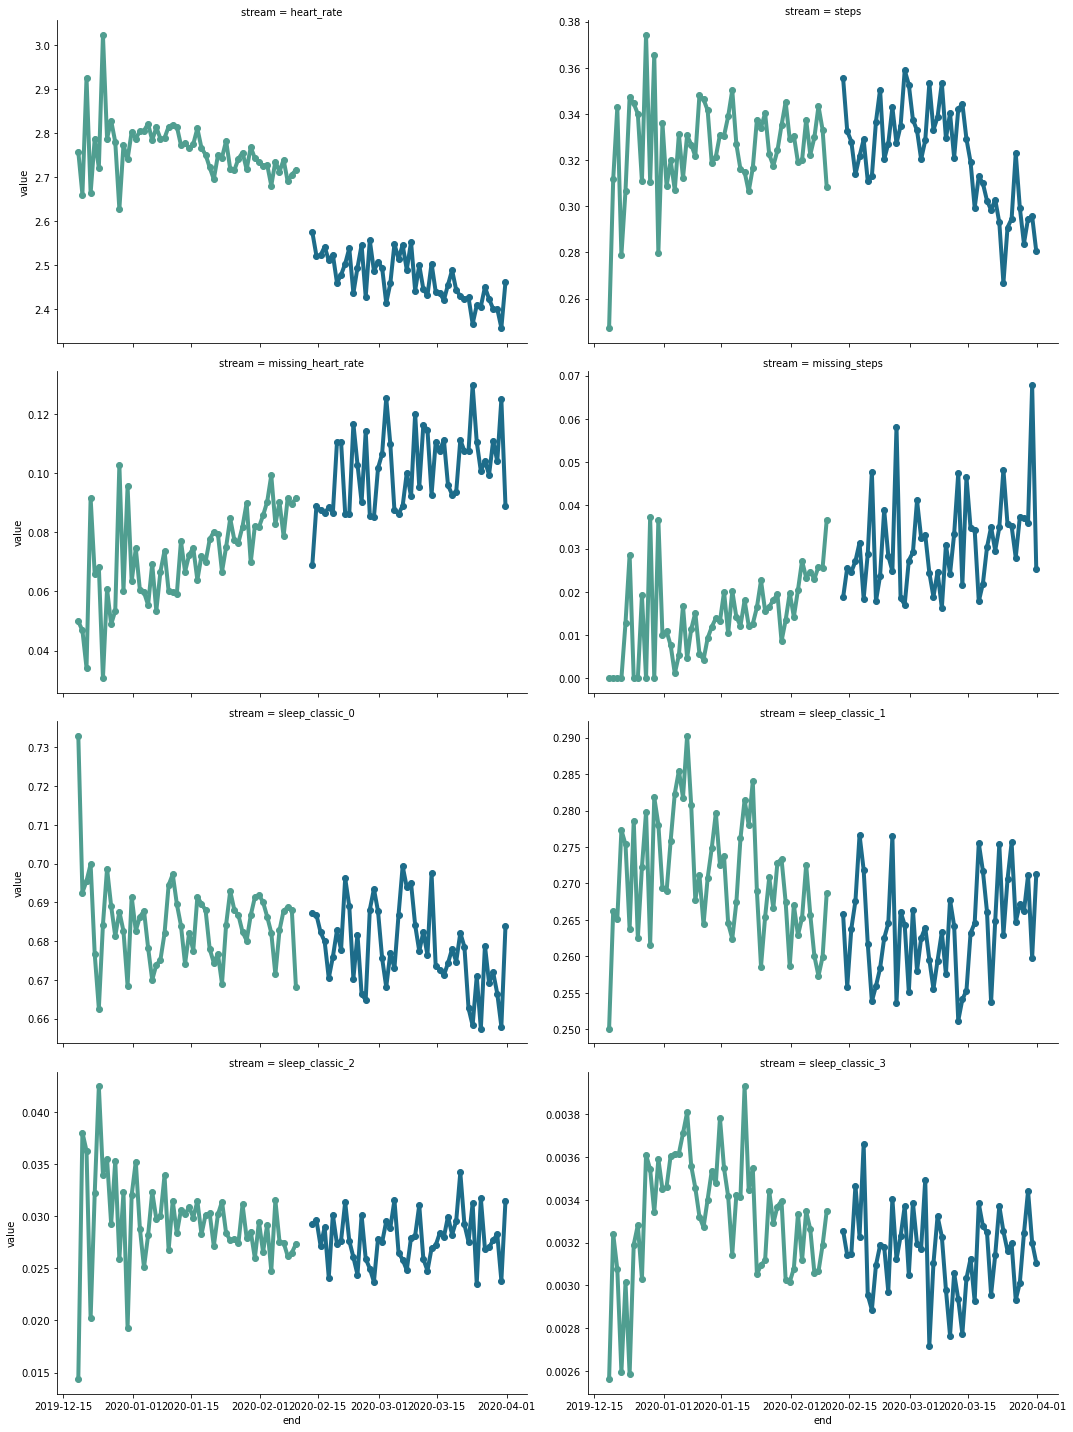

In [6]:

plot_train_val_means(train_df,val_df)

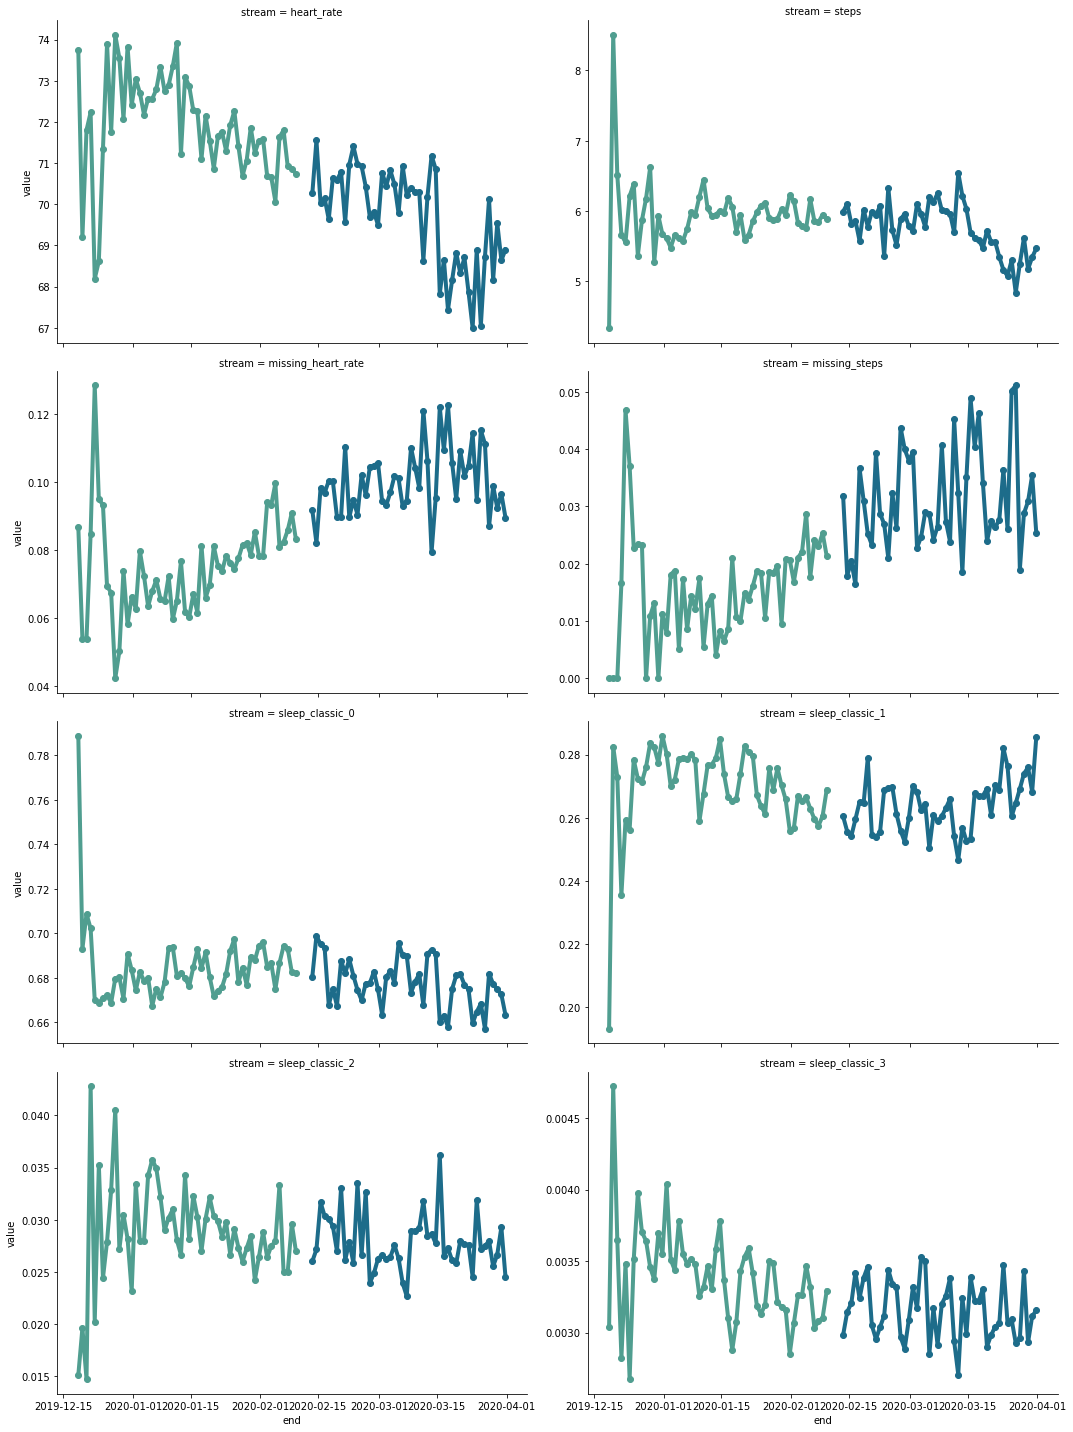

In [7]:
## Created some non - normalized features:
NO_SCALE_TRAIN_PATH = "/projects/bdata/datasets/gatesfoundation/processed/split/audere_split_2020-02-10/train_minute_no_scale_petastorm/"
NO_SCALE_VAL_PATH = "/projects/bdata/datasets/gatesfoundation/processed/split/audere_split_2020-02-10/eval_minute_no_scale_petastorm/"

no_scale_train_df = spark.read.parquet(NO_SCALE_TRAIN_PATH).sample(fraction=0.1).toPandas()
no_scale_val_df = spark.read.parquet(NO_SCALE_VAL_PATH).sample(fraction=0.1).toPandas()

plot_train_val_means(no_scale_train_df, no_scale_val_df)

In [8]:
no_scale_train_df.head()

,participant_id,window,steps,heart_rate,missing_heart_rate,missing_steps,sleep_classic_0,sleep_classic_1,sleep_classic_2,sleep_classic_3,count_col,start,end,id,type
0,01c5a05276d5f4c670cf4c0db037373e,"(2020-01-18 16:00:00, 2020-01-22 16:00:00)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[60.0, 59.0, 59.0, 58.0, 58.0, 59.0, 58.0, 60....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-01-18 16:00:00,2020-01-22 16:00:00,652835028997,train
1,024f97918e549665e797340c8a99c793,"(2020-01-07 16:00:00, 2020-01-11 16:00:00)","[0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[69.0, 70.0, 70.0, 75.0, 71.0, 69.0, 67.0, 67....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, False, True, True, True, False, T...","[False, False, True, False, False, False, True...","[False, False, False, False, False, False, Fal...",5760,2020-01-07 16:00:00,2020-01-11 16:00:00,652835029001,train
2,032c564bfaebe4a2a0eb15cd4e58d81a,"(2020-01-21 16:00:00, 2020-01-25 16:00:00)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[81.0, 81.0, 83.0, 82.0, 83.0, 82.0, 81.0, 82....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-01-21 16:00:00,2020-01-25 16:00:00,652835029008,train
3,0545edaee9e7a03877d527f8b4331b81,"(2020-01-24 16:00:00, 2020-01-28 16:00:00)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[75.0, 75.0, 75.0, 79.0, 70.0, 73.0, 73.0, 69....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-01-24 16:00:00,2020-01-28 16:00:00,652835029012,train
4,0c4637bb834afc95a3c57b431b788cb0,"(2020-01-09 16:00:00, 2020-01-13 16:00:00)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[67.0, 73.0, 62.0, 69.0, 64.0, 65.0, 65.0, 67....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, False, False, True, T...","[False, False, False, False, True, True, False...","[False, False, False, False, False, False, Fal...",5760,2020-01-09 16:00:00,2020-01-13 16:00:00,652835029042,train


In [9]:
no_scale_train_df["day_type"] = np.where(no_scale_train_df["end"].dt.weekday.isin([5,6]),"weekend","weekday")
no_scale_val_df["day_type"] = np.where(no_scale_val_df["end"].dt.weekday.isin([5,6]),"weekend","weekday")

In [10]:
NUMERIC_FEATURES = ["heart_rate","steps"]
NUMERIC_FEATURES_NORMED = ["heart_rate_normed","steps_normed"]
def norm(x):
    x = np.array(x)
    result =  (x-x.mean()) / x.std()
    if np.any(np.isnan(result)):
        return np.nan
    return result

no_scale_val_df[NUMERIC_FEATURES_NORMED] = no_scale_val_df[NUMERIC_FEATURES].applymap(norm)
no_scale_train_df[NUMERIC_FEATURES_NORMED] = no_scale_train_df[NUMERIC_FEATURES].applymap(norm)

/homes/gws/mikeam/miniconda3/envs/seattleflustudy/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [11]:
eval_results = {}
for k,v in no_scale_val_df[["day_type","steps_normed"]].groupby("day_type"):
    for column in v.columns:
        if column == "day_type":
            continue
        all_days = np.stack(v[column].dropna().values)
        eval_results[k] = all_days.mean(axis=0)


train_results = {}
for k,v in no_scale_train_df[["day_type","steps_normed"]].groupby("day_type"):
    for column in v.columns:
        if column == "day_type":
            continue
        all_days = np.stack(v[column].dropna().values)
        train_results[k] = all_days.mean(axis=0)

        

Text(0.5, 0, 'Minute of Window')

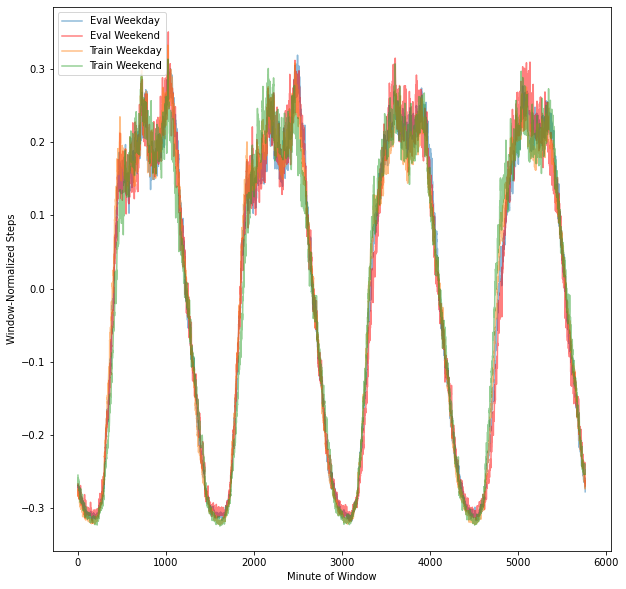

In [12]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(range(24*60*4),eval_results["weekday"],alpha=0.5,label="Eval Weekday")
plt.plot(range(24*60*4),eval_results["weekend"],color="red",alpha=0.5, label="Eval Weekend")
plt.plot(range(24*60*4),train_results["weekday"],alpha=0.5,label="Train Weekday")
plt.plot(range(24*60*4),train_results["weekend"],alpha=0.5, label="Train Weekend")
plt.legend()
plt.ylabel("Window-Normalized Steps")
plt.xlabel("Minute of Window")
# plt.show()

In [13]:
train_results

{'weekday': array([-0.27904763, -0.27408528, -0.28094259, ..., -0.27335286,
        -0.26762735, -0.2611552 ]),
 'weekend': array([-0.25456822, -0.25811808, -0.26928073, ..., -0.25205676,
        -0.2477981 , -0.25294701])}

In [14]:
def plot_train_val_days(train_df,val_df,label="is_weekend"):
    train_df["type"] = "train"
    val_df["type"] = "val"
    all_df = pd.concat([train_df,val_df],axis=0)
    all_df.groupby("type")[FEATURE_COLUMNS].aggregate(lambda x: np.concatenate(x.values).mean())
    
    mean_by_day = all_df.groupby(["type","end"])[FEATURE_COLUMNS].aggregate(lambda x: np.concatenate(x.values).mean())
    val_mean_by_day = mean_by_day.xs("val",level=0)
    train_mean_by_day = mean_by_day.xs("val",level=0)
    
    stacked_daily_means = mean_by_day.stack().rename("value").reset_index()
    stacked_daily_means = stacked_daily_means.rename(columns={"level_2":"stream"})
    
    g = sns.FacetGrid(
    data=stacked_daily_means,
    col="stream", hue="type",
    palette="crest",  
    col_wrap=2, height=5, aspect=1.5, sharey=False
    )
    
    g.map(plt.plot, "end", "value", marker="o", linewidth=4)
    
    return g

Are there discontinuties between days? This could indicate that something has gone wrong with preparing the windows:

In [15]:
from scipy.ndimage.interpolation import shift
val_diffs = no_scale_val_df["heart_rate"].map(lambda x: x - shift(x,-1,cval=np.nan)).values
val_diffs_means = val_diffs.mean(axis=0)

Text(0.5, 1.0, 'Heart Rate')

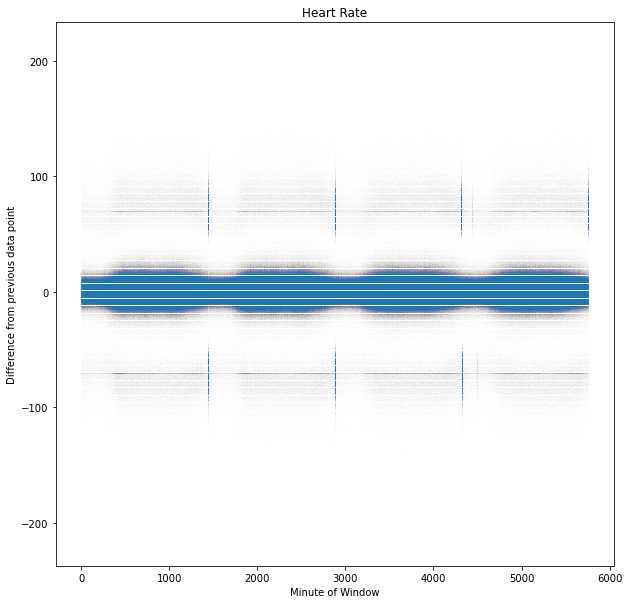

In [20]:
%matplotlib inline
val_diff_n = len(val_diffs)
val_diff_k = len(val_diffs[0])
val_diff_x = np.tile(np.arange(val_diff_k),val_diff_n)
plt.figure(figsize=(10,10))
plt.scatter(val_diff_x,np.concatenate(val_diffs), alpha=0.005, s=0.5)
plt.xlabel("Minute of Window")
plt.ylabel("Difference from previous data point")
plt.title("Heart Rate")

In [29]:
# Where are these spikes?
max_val_locs = no_scale_val_df["heart_rate"].map((lambda x: np.nanargmax(x - shift(x,-1,cval=np.nan))))
max_val_locs.value_counts()

0       267
1438    249
5758    234
2878    216
4318    202
       ... 
2127      1
412       1
4651      1
2739      1
2034      1
Name: heart_rate, Length: 4231, dtype: int64

In [39]:
first_with_spike = no_scale_val_df.loc[max_val_locs[max_val_locs == 1438].index[0]]

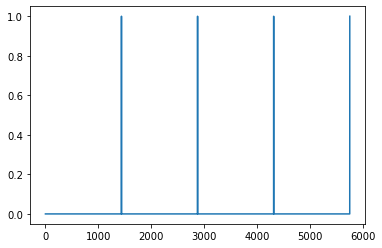

In [41]:
plt.plot(range(60*4*24),first_with_spike["missing_heart_rate"])